Estadistica Aplicada - Proyecto Integrador del Aprendizaje (PIA)

Salvador Almaguer Orta - 2076430 

Originalmente del grupo 41, peor iba a clase en el grupo 44

Nombre de equipo: 3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6)
import seaborn as sns
sns.set() # Para visualizar mejor la grafica

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

In [3]:
datos = pd.read_csv('https://raw.githubusercontent.com/jimmyzac/Estadistica-Aplicada-FCFM-UANL/main/bases_datos/credit_risk.csv')
datos

,saldo_cuenta,meses,historia_crediticia,uso,cantidad,saldo_cuenta_ahorro,años_trabajando,tasa_de_interes,genero_estado_civil,aval,...,activos,edad,planes_de_pago,casa,numero_creditos,situacion_laboral,dependientes_economicos,telefono,extranjero,credito_pagado
0,menor_a_cero,6,no_ha_pagado,TV,1169,NaN,mas_de_7,4,hombre_soltero,NaN,...,bienes_raices,67,NaN,propia,2,gobierno,1,1,1,1
1,cero_a_200,48,pago_algun_credito,TV,5951,menor_100,1_a_4,2,mujer_no_soltera,NaN,...,bienes_raices,22,NaN,propia,1,gobierno,1,0,1,0
2,sin_cuenta,12,no_ha_pagado,colegiaturas,2096,menor_100,4_a_7,2,hombre_soltero,NaN,...,bienes_raices,49,NaN,propia,1,obrero,2,0,1,1
3,menor_a_cero,42,pago_algun_credito,mobiliario,7882,menor_100,4_a_7,2,hombre_soltero,aval,...,seguro_vida,45,NaN,prestada,1,gobierno,2,0,1,1
4,menor_a_cero,24,pago_retrasado,coche_nuevo,4870,menor_100,1_a_4,3,hombre_soltero,NaN,...,sin_activos,53,NaN,prestada,2,gobierno,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,sin_cuenta,12,pago_algun_credito,mobiliario,1736,menor_100,4_a_7,3,mujer_no_soltera,NaN,...,bienes_raices,31,NaN,propia,1,obrero,1,0,1,1
996,menor_a_cero,30,pago_algun_credito,coche_usado,3857,menor_100,1_a_4,4,hombre_divorciado,NaN,...,seguro_vida,40,NaN,propia,1,administrativo,1,1,1,1
997,sin_cuenta,12,pago_algun_credito,TV,804,menor_100,mas_de_7,4,hombre_soltero,NaN,...,otro_tipo,38,NaN,propia,1,gobierno,1,0,1,1
998,menor_a_cero,45,pago_algun_credito,TV,1845,menor_100,1_a_4,4,hombre_soltero,NaN,...,sin_activos,23,NaN,prestada,1,gobierno,1,1,1,0


# 1. Introducción

La base de datos a analizar llamada "credit_risk" (Riesgo de credito) la cual se compone de de 1000 registros de clientes de un banco, esta base mide el riesgo el reisgo que tienen los clientes de pagar o no su credito en base a su suledo, historial, tamaño del credito (cantidad), ahorros, tiempo tarbajando, enero, edad, situacion laboral, si es extranjero, entre otras.

El evento de la base es si estos clientes han pagado su credito

Y las dimenciones de la base estan en un periodo mensual

# 2. ¿Por que es importante el analisis de supervivencia en esta base de datos?

Para el banco en cuestion es muy importante conocer la probabilidad de que sus clientes paguen este credito, la importancia de conocer esto es para clasificar a los clientes y en base a este criterio decidir si es o no riesgoso el otorgar otro credito a clientes con similares caracteristicas.

# 3. Datos censurados

In [4]:
datos['credito_pagado'].value_counts()

credito_pagado
1    700
0    300
Name: count, dtype: int64

En base al codigo anterior, podemos identificar que:
Se presentan 700 valores de 1, los cuales significan que 700 clienets ya pagaron su credito.
Y 300 valores 0, los cuales significan que aun no han pagado su credito.

Por lo tanto estos 300 valores de 0 son nuestros datos censurados, lo que queire decir que, estos 300 clientes no sabemos cuando pagaran su credito.


# 4. Dummies

In [5]:
datos.dtypes

saldo_cuenta               object
meses                       int64
historia_crediticia        object
uso                        object
cantidad                    int64
saldo_cuenta_ahorro        object
años_trabajando            object
tasa_de_interes             int64
genero_estado_civil        object
aval                       object
años_actual_domicilio       int64
activos                    object
edad                        int64
planes_de_pago             object
casa                       object
numero_creditos             int64
situacion_laboral          object
dependientes_economicos     int64
telefono                    int64
extranjero                  int64
credito_pagado              int64
dtype: object

Debemos combertir en variables numericas las variables que tienen como tipo de datos 'object'

In [6]:
datos_dummies = datos

In [7]:
dummie_saldo_cuenta = pd.get_dummies(datos_dummies["saldo_cuenta"]).astype("int64")
dummie_saldo_cuenta = dummie_saldo_cuenta[["sin_cuenta", "cero_a_200", "mas_de_200"]]

datos_dummies = pd.concat([datos_dummies,dummie_saldo_cuenta],axis=1)
datos_dummies = datos_dummies.drop('saldo_cuenta',axis=1)

In [8]:
dummie_historia_crediticia = pd.get_dummies(datos_dummies["historia_crediticia"]).astype("int64")
dummie_historia_crediticia = dummie_historia_crediticia.drop("no_ha_pagado", axis=1)

datos_dummies = pd.concat([datos_dummies,dummie_historia_crediticia],axis=1)
datos_dummies = datos_dummies.drop('historia_crediticia',axis=1)

In [9]:
dummie_uso = pd.get_dummies(datos_dummies["uso"]).astype("int64")
dummie_uso = dummie_uso.drop("utensilios_hogar", axis=1)

datos_dummies = pd.concat([datos_dummies,dummie_uso],axis=1)
datos_dummies = datos_dummies.drop('uso',axis=1)

In [10]:
dummie_saldo_cuenta_ahorro = pd.get_dummies(datos_dummies["saldo_cuenta_ahorro"]).astype("int64")
dummie_saldo_cuenta_ahorro = dummie_saldo_cuenta_ahorro[["menor_100", "100_a_500", "500_a_1000"]]

datos_dummies = pd.concat([datos_dummies,dummie_saldo_cuenta_ahorro],axis=1)
datos_dummies = datos_dummies.drop('saldo_cuenta_ahorro',axis=1)

In [11]:
dummie_años_trabajando = pd.get_dummies(datos_dummies["años_trabajando"]).astype("int64")
dummie_años_trabajando = dummie_años_trabajando.drop("mas_de_7", axis=1)

datos_dummies = pd.concat([datos_dummies,dummie_años_trabajando],axis=1)
datos_dummies = datos_dummies.drop('años_trabajando',axis=1)

In [12]:
dummie_genero_estado_civil = pd.get_dummies(datos_dummies["genero_estado_civil"]).astype("int64")
dummie_genero_estado_civil = dummie_genero_estado_civil[["hombre_soltero", "mujer_no_soltera"]]

datos_dummies = pd.concat([datos_dummies,dummie_genero_estado_civil],axis=1)
datos_dummies = datos_dummies.drop('genero_estado_civil',axis=1)

In [13]:
dummie_aval = pd.get_dummies(datos_dummies["aval"]).astype("int64")

datos_dummies = pd.concat([datos_dummies,dummie_aval],axis=1)
datos_dummies = datos_dummies.drop('aval',axis=1)

In [14]:
dummie_activos = pd.get_dummies(datos_dummies["activos"]).astype("int64")
dummie_activos = dummie_activos.drop("otro_tipo", axis=1)

datos_dummies = pd.concat([datos_dummies,dummie_activos],axis=1)
datos_dummies = datos_dummies.drop('activos',axis=1)

In [15]:
dummie_planes_de_pago = pd.get_dummies(datos_dummies["planes_de_pago"]).astype("int64")
dummie_planes_de_pago = dummie_planes_de_pago.drop("departamental", axis=1)

datos_dummies = pd.concat([datos_dummies,dummie_planes_de_pago],axis=1)
datos_dummies = datos_dummies.drop('planes_de_pago',axis=1)

In [16]:
dummie_casa = pd.get_dummies(datos_dummies["casa"]).astype("int64")
dummie_casa = dummie_casa[["propia", "renta"]]

datos_dummies = pd.concat([datos_dummies,dummie_casa],axis=1)
datos_dummies = datos_dummies.drop('casa',axis=1)

In [17]:
dummie_situacion_laboral = pd.get_dummies(datos_dummies["situacion_laboral"]).astype("int64")
dummie_situacion_laboral = dummie_situacion_laboral.drop("administrativo", axis=1)

datos_dummies = pd.concat([datos_dummies,dummie_situacion_laboral],axis=1)
datos_dummies = datos_dummies.drop('situacion_laboral',axis=1)

In [18]:
datos_dummies.dtypes

meses                      int64
cantidad                   int64
tasa_de_interes            int64
años_actual_domicilio      int64
edad                       int64
numero_creditos            int64
dependientes_economicos    int64
telefono                   int64
extranjero                 int64
credito_pagado             int64
sin_cuenta                 int64
cero_a_200                 int64
mas_de_200                 int64
pago_algun_credito         int64
pago_retrasado             int64
pago_todos                 int64
sin_creditos               int64
TV                         int64
coche_nuevo                int64
coche_usado                int64
colegiaturas               int64
mobiliario                 int64
otros                      int64
poner_negocio              int64
reestructuración           int64
reparaciones               int64
menor_100                  int64
100_a_500                  int64
500_a_1000                 int64
1_a_4                      int64
4_a_7     

Hora todas las variables son numericas

# 5. Missing values y duplicados

In [19]:
print(f'Missing values: {datos_dummies.isnull().sum().sum()}')
print(f'Duplicados: {datos_dummies.duplicated().sum()}')

Missing values: 0
Duplicados: 0


La base de datos no presenta missing values ni duplicados

# 6. Estadisticas descriptivas

In [20]:
datos.describe()

,meses,cantidad,tasa_de_interes,años_actual_domicilio,edad,numero_creditos,dependientes_economicos,telefono,extranjero,credito_pagado
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.404000,0.963000,0.700000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.490943,0.188856,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000,1.000000,1.000000


# 7. Caracteristicas de la base de datos

### a) Cuantas variables y cuantas observaciones tienen la base

In [61]:
datos_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   meses                    1000 non-null   int64
 1   cantidad                 1000 non-null   int64
 2   tasa_de_interes          1000 non-null   int64
 3   años_actual_domicilio    1000 non-null   int64
 4   edad                     1000 non-null   int64
 5   numero_creditos          1000 non-null   int64
 6   dependientes_economicos  1000 non-null   int64
 7   telefono                 1000 non-null   int64
 8   extranjero               1000 non-null   int64
 9   credito_pagado           1000 non-null   int64
 10  sin_cuenta               1000 non-null   int64
 11  cero_a_200               1000 non-null   int64
 12  mas_de_200               1000 non-null   int64
 13  pago_algun_credito       1000 non-null   int64
 14  pago_retrasado           1000 non-null   int64
 15  pago_

La base con las dummies cuenta con 44 cariables (columnas) y 1000 registros cada una.

### b) Cuál es el monto promedio de los créditos otorgados por el banco

In [22]:
monto_promedio = round(datos_dummies['cantidad'].mean(),2)
print('El monto promedio de los creditos otorgados por el banco a sus clientes es de:', monto_promedio, 'Euros')

El monto promedio de los creditos otorgados por el banco a sus clientes es de: 3271.26 Euros


### c)  Cuál es el tiempo promedio que se tardaron en pagar el préstamo los que pagaron el préstamo en su totalidad

In [23]:
pago_promedio = (round(datos_dummies.query('credito_pagado==1')['meses'].mean(),2))
print("El tiempo promedio que tardaron en pagar sus prestamos los que ya lo pagaron por completo, es de:", pago_promedio, "meses")

El tiempo promedio que tardaron en pagar sus prestamos los que ya lo pagaron por completo, es de: 19.21 meses


### d)  Cuál es la tasa de interés promedio otorgada por el banco

In [24]:
tasa_interes_promedio = datos_dummies["tasa_de_interes"].mean()
print('La tasa de interes promedio otorgada por el banco es de ',tasa_interes_promedio, '%')

La tasa de interes promedio otorgada por el banco es de  2.973 %


### e)  Cuál es el monto promedio y la tasa de interés promedio de los que ya pagaron

In [25]:
monto_promedio_pagaron = round(datos_dummies.query("credito_pagado==1")["cantidad"].mean(),2)
tasa_interes_promedio_pagaron = datos_dummies.query("credito_pagado==1")["tasa_de_interes"].mean()

print("El monto promedio prestado a los clientes que ya pagaron su prestamo fue de:", monto_promedio_pagaron, 'Euros')
print("Con una tasa de interes de:", tasa_interes_promedio_pagaron,'%')

El monto promedio prestado a los clientes que ya pagaron su prestamo fue de: 2985.46 Euros
Con una tasa de interes de: 2.92 %


### f) Cuál es el monto promedio y la tasa de interés promedio de los que no han pagado 

In [26]:
monto_promedio_no_pagaron = round(datos_dummies.query("credito_pagado==0")["cantidad"].mean(),2)
tasa_interes_promedio_no_pagaron = round(datos_dummies.query("credito_pagado==0")["tasa_de_interes"].mean(),2)

print("El monto promedio prestado a los que ya pagaron su prestamo fue de:", monto_promedio_no_pagaron, 'Euros')
print("con una tasa de interes de:", tasa_interes_promedio_no_pagaron, '%')

El monto promedio prestado a los que ya pagaron su prestamo fue de: 3938.13 Euros
con una tasa de interes de: 3.1 %


# 8. Tiempo promedio de supervivencia

In [27]:
print("El tiempo promedio de supervivencia de la base de datos es:", round(datos_dummies["meses"].mean(),2),'meses')

El tiempo promedio de supervivencia de la base de datos es: 20.9 meses


# 9.  Calcula la función de supervivencia y grafícala utilizando Kaplan-Meier y obtén la mediana ¿qué significa la mediana?

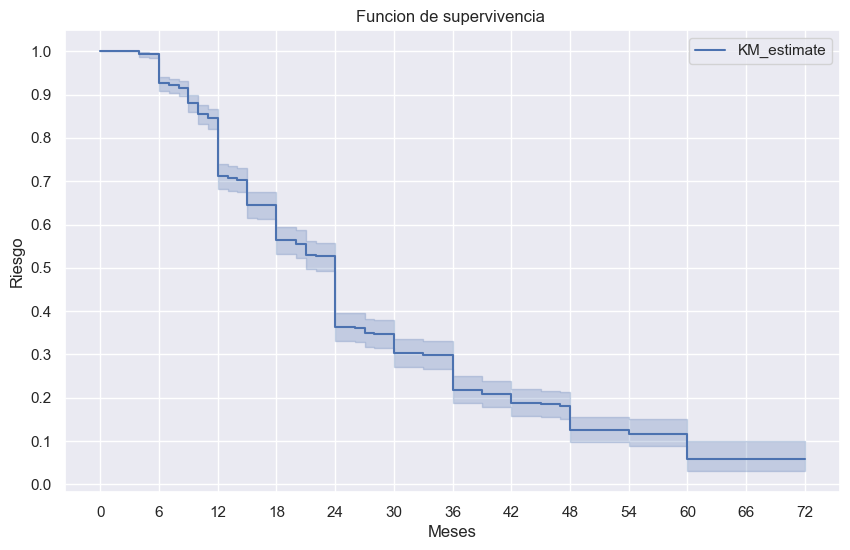

24.0

In [58]:
km1 = KaplanMeierFitter().fit(datos_dummies["meses"], datos_dummies["credito_pagado"])
km1.plot_survival_function()
plt.title('Funcion de supervivencia ')
plt.xlabel('Meses')
plt.ylabel('Riesgo')
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(range(0,73,6))
plt.show()
km1.median_survival_time_

La mediana del tiempo que tardan en pagar los clientes es de 24 meses, esto significa que la mitad de la gente pago antes de los 24 meses

# 10. Elige construye una variable (por ejemplo, para la del crédito bancario, si debe más de 500 mil 1, y 0 si debe menos), estima y grafica la función de supervivencia por Kaplan-meier para cada grupo

In [29]:
datos['credito_bancario'] = (datos['cantidad'] > 10000).astype(int)

In [30]:
credito_alta = datos.query('credito_bancario==1')
credito_baja = datos.query('credito_bancario==0')

In [31]:
km2a = KaplanMeierFitter().fit(credito_alta['meses'], credito_alta['credito_pagado'])
km2b = KaplanMeierFitter().fit(credito_baja['meses'], credito_baja['credito_pagado'])

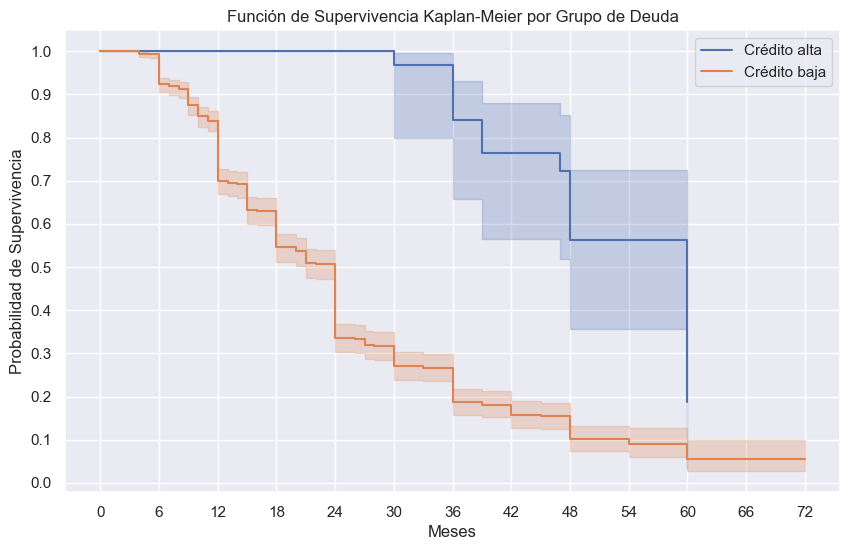

In [59]:
plt.figure(figsize=(10, 6))
km2a.plot_survival_function(label='Crédito alta')
km2b.plot_survival_function(label='Crédito baja')
plt.xlabel('Meses')
plt.ylabel('Probabilidad de Supervivencia')
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(range(0,73,6))
plt.title('Función de Supervivencia Kaplan-Meier por Grupo de Deuda')
plt.show()

# 11. Prueba Si las funciones de supervivencia son distintas usando el log rank test y comenta el resultado


In [33]:
logrt=logrank_test(credito_alta['meses'], credito_baja['meses'], credito_alta['credito_pagado'], credito_baja['credito_pagado'])
logrt.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          47.29 <0.005     37.25

In [34]:
pvalor = logrt.p_value.round(2)

In [35]:
print(f'Ho: Las funcines de supervivencia son iguales\nHa: Las funcines de supervivencia no son iguales\n\np_valor = {pvalor.round(2)} < 0.05\nRechazamos H0. Las funciones de supervivencia son distintas.\nLos individuos con el credito de alta deuda tienen una mayor probabilidad de pagar el credito en comparacion con los de credito bajo.')

Ho: Las funcines de supervivencia son iguales
Ha: Las funcines de supervivencia no son iguales

p_valor = 0.0 < 0.05
Rechazamos H0. Las funciones de supervivencia son distintas.
Los individuos con el credito de alta deuda tienen una mayor probabilidad de pagar el credito en comparacion con los de credito bajo.


# 12. Ahora estima un modelo de Cox

### a) A parte de “tasa de interes” y “cantidad”, elige otras cuatro variables que creas que afectan el riesgo del evento

Para la estimacion del modelo de Cox se escogieron las sigientes variables:

- **edad**
- **casa**
- **extranjero**
- **numero_creditos**

### b) Di si cada una de las 6 variables que elegiste, aumentan/disminuyen el riesgo del evento y por qué

- **cantidad**: Se esperaria que por cada euro prestado el riesgo de pagar el credito disminuya a causa de que el monto al ser mayor, seria mas dificil para los prestatarios conseguir dicha natidad.

- **tasa de interes**: Se espera que mientras mayor sea el interes, el riesgo de pagar el credito diminuya a causa de que para los prestatarios sera mas dificil solventar el prestamo mientras mayor sea la tasa de interes.

- **edad**: Esperaria que mientras mayor edad tenga los prestatarios tengan una economia mas estable y puedan pagar antes o aumente el riesgo de pagar su deuda.

- **casa**: Se espera que al tener casa propia, entonces, de esta manera signifique que tenga una economia mas estable y pueda pagar antes o aumente el riesgo de pagar su deuda en comparacion con los que no tienen casa propia.

- **extranjero**: Al ser un prestatario de otra nacion, su compromiso con saldar la deuda con bancos de otra nacionalidad no es tan grande y por l tanto se esperaria que esta variable disminuya el reisgo de pagar la deuda.

- **numero_creditos**: Al contar con mayor cantidad de creditos, considerando que mientras mas creditos tenga es porque si suele pagar pensando en que si el banco les presto antes y pago, entonces, es un prestatario que si suele pagar sus prestamos. Asi que se esperaria que esta variable aumente el riesgo de pagar el credito.

### c) Realiza las transformaciones adecuadas para utilizar las variables en un modelo de cox

In [36]:
datos_cox = datos[['credito_pagado', 'meses', 'tasa_de_interes', 'cantidad', 'edad', 'casa', 'extranjero', 'numero_creditos']]
datos_cox['casa'] = np.where(datos_cox['casa'] == 'propia', 1, 0) # la variable casa se tomara como 1-> si tine casa propia, 0-> si no tiene casa propia

datos_cox.isnull().sum().sum()

C:\Users\A\AppData\Local\Temp\ipykernel_4856\3730355494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_cox['casa'] = np.where(datos_cox['casa'] == 'propia', 1, 0) # la variable casa se tomara como 1-> si tine casa propia, 0-> si no tiene casa propia


0

La nueva base tiene solo variables numericas y sin missing values

### d) Estima un modelo de cox con las variables elegidas e interpreta los coeficientes

In [37]:
cph = CoxPHFitter().fit(datos_cox, 'meses', 'credito_pagado')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1000 total observations, 300 right-censored observations>
             duration col = 'meses'
                event col = 'credito_pagado'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 700
   partial log-likelihood = -4039.72
         time fit was run = 2023-11-13 06:04:54 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
tasa_de_interes  -0.41       0.67       0.04            -0.48            -0.33                 0.62                 0.72
cantidad         -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
edad              0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
casa              0.21       1.23       0.09             0.04             0.38                 1.04                 1.46
extranjero       -1.20       0.30       0.18            -1.56            -0.84                 0.21                 0.43
numero_creditos   0.12       1.12       0.07            -0.01             0.25                 0.99                 1.28

                  cmp to      z      p   -log2(p)
covariate                                        
tasa_de_interes     0.00 -11.08 <0.005      92.44
cantidad            0.00 -16.13 <0.005     192.12
edad                0.00   4.54 <0.005      17.47
casa                0.00   2.36   0.02       5.77
extranjero          0.00  -6.50 <0.005      33.53
numero_creditos     0.00   1.74   0.08       3.61
---
Concordance = 0.78
Partial AIC = 8091.43
log-likelihood ratio test = 459.34 on 6 df
-log2(p) of ll-ratio test = 316.64

- **tasa_de_interes:** Debido a que el p_valor < 0.05; Entonces esta variable si afecta al riesgo de pagar el credito, y por cada punto de porcentaje (1%) de interes el riesgo diminuye en 33% (suponiendo que en la tabla 2 significa 2%).

- **cantidad:** Debido a que el p_valor < 0.05; Entonces esta variable si afecta al riesgo de pagar el credito, y por cada Euro el riesgo de pagar el credito dismimuye en 0.00037%.

- **edad:** Debido a que el p_valor < 0.05; Entonces esta variable si afecta al riesgo de pagar el credito, y por cada año de edad el riesgo de pagar el credito aumenta en 2%.

- **casa:** Debido a que el p_valor < 0.05; Entonces esta variable si afecta al riesgo de pagar el credito, y por tener casa propia aumenta el riesgo de pagar el credito en 23% en comparacion con no tener casa propia.

- **extranjero:** Debido a que el p_valor < 0.05; Entonces esta variable si afecta al riesgo de pagar el credito, y por ser extranjero disminuye el riesgo de pagar el credito en 70% en comparacion con no ser extranjero.

- **numero_creditos:** Debido a que el p_valor > 0.05; Entonces esta variable NO afecta al riesgo de pagar el credito.

# 13. Interpreta cada uno de los coeficientes obtenidos. Utiliza cph.plot() para ayudarte con la interpretación.

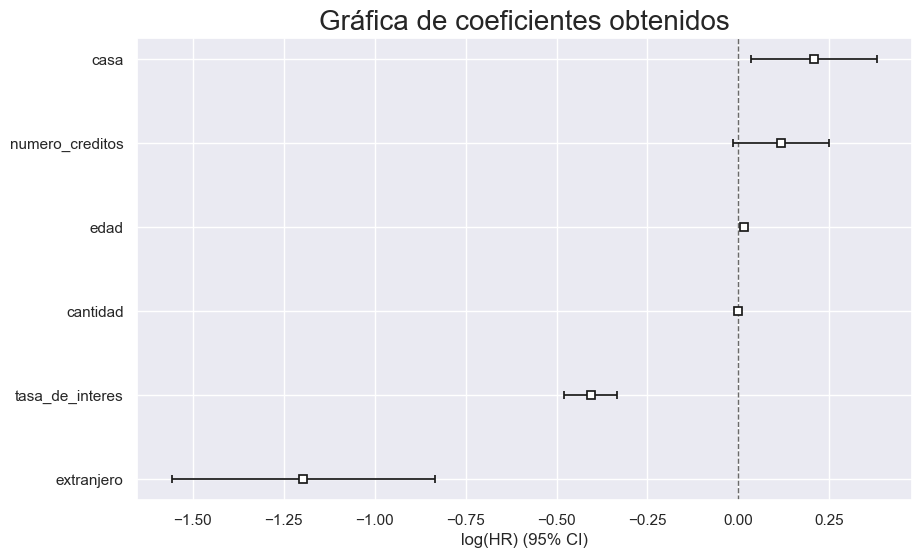

In [66]:
cph.plot()
plt.title("Gráfica de coeficientes obtenidos", fontsize=20)
plt.show()

El significaod de esta grafica nos sirve para saber que variables son significativas. La grafica nos dice que si el intervalo de confianza del 95% abarca el 0, entonces esta variable no afecta, ademas de utilizar la interpretacion con el p_valor.

Como podemos ver la unica variable que contiene el 0 en su intervao de confianza es la variable 'numero_creditos'.
Para las variables de 'cantidad' y 'edad' se podria confundir un poco mediante la grafica, pero a travez del punto anterior en el resumen del modelo podmos ver que los intervalos de confianza para:

- 'edad' [0.01 a 0.02]
- 'cantidad [-0 a -0] (el simbolo negativo nos confirma que su intervalo es de un valor negaivo a otro negativo, entonces el 0 no lo abarca).

# 14. Con base en los cálculos realizados, redacta un comentario integral de por lo menos 250 palabras que resuma el análisis, reflexiones y recomendaciones sobre la política de otorgamiento de créditos en el Banco de la Ilusión. 

En este análisis, nuestro objetivo era estudiar el comportamiento de los clientes que solicitan préstamos y los factores que influyen en el riesgo de impago. Para ello, utilizamos una muestra de datos de 1000 clientes que solicitaron préstamos entre enero y diciembre de 2023. Los datos incluían variables como la cantidad solicitada, la tasa de interés, el plazo, la edad, el estado civil, el nivel educativo, el tipo de vivienda y la nacionalidad.


Con las actuales políticas, el monto promedio de préstamo por cliente es de 3271.25 Euros y en promedio se tardan en pagar el crédito 21 meses, pero la mitad de los prestatarios pagan antes de los 24 meses. La tasa de interés promedio es de 2.973% y el riesgo de impago tiene una forma tipo log-normal. Esto significa que la mayoría de los clientes tienen un riesgo bajo o moderado, pero hay algunos casos extremos con un riesgo muy alto.


También descubrimos que aparte de las variables de ‘tasa de interés’ y ‘cantidad’, otras buenas variables que influyen en el riesgo de impago en nuestro modelo son las variables ‘edad’, ‘casa’ y ‘extranjero’. Observamos que a mayor edad, menor es el riesgo de impago, lo que puede deberse a una mayor estabilidad financiera y laboral. Asimismo, tener una casa propia reduce el riesgo de impago, ya que implica un menor gasto en alquiler y una mayor capacidad de ahorro. Por último, ser extranjero disminuye mucho la probabilidad de no pagar el crédito en comparación con no ser extranjero. Esto puede deberse a que los extranjeros tienen más dificultades para acceder al crédito y por tanto son más cuidadosos a la hora de devolverlo.

Por lo tanto, se recomienda regular las políticas de préstamo a extranjeros, ya que son un segmento con un alto riesgo de inpago y una alta demanda potencial. También se sugiere revisar los criterios de elegibilidad y las condiciones de los préstamos para adaptarlos mejor al perfil y las necesidades de cada cliente.


# 15. Por último, investiga y señala las limitaciones de Kaplan-Meier y del modelo de Cox 

#### Kaplan-Meier
- Asume que la censura es no informativa, es decir, que los casos censurados tienen la misma probabilidad de supervivencia que los casos no censurados. Esta suposición puede no ser válida si existen factores o tratamientos variables en el tiempo que puedan influir en las probabilidades de supervivencia.

- No permite incorporar variables explicativas o covariables que puedan afectar a la supervivencia.

- No es adecuado para analizar datos de supervivencia en presencia de riesgos competitivos, es decir, cuando hay más de un tipo de evento que impide la ocurrencia del evento de interés.

- Proporciona estimaciones puntuales de la función de supervivencia, pero no intervalos de confianza para la mediana o la media de supervivencia. Además, los intervalos de confianza para la función de supervivencia pueden ser asimétricos y no contener el valor estimado.

- Requiere que los datos de supervivencia sean continuos, lo que puede no ser cierto si hay agrupamiento o intervalos de tiempo discretos. En estos casos, se pueden utilizar métodos como el de actuarial o el de Nelson-Aalen.

### Modelo de Cox

- Asume que los riesgos son proporcionales, es decir, que la relación entre los riesgos de muerte entre dos individuos expuestos a factores distintos no varía en función del tiempo. Esta suposición puede no ser válida si hay efectos dependientes del tiempo o interacciones entre las covariables y el tiempo.

- No proporciona una estimación directa de la función de supervivencia, sino solo de la función de riesgo. Para obtener la función de supervivencia, se requiere conocer la función de riesgo de referencia, que no se estima por el modelo de Cox, sino por otros métodos como el de Kaplan-Meier.

- Puede ser sensible a la presencia de valores atípicos o influyentes, que pueden distorsionar las estimaciones de los parámetros y los intervalos de confianza.

- El modelo de Cox puede tener problemas de convergencia o singularidad si hay multicolinealidad entre las covariables, es decir, si hay una alta correlación entre ellas. Esto puede provocar que las estimaciones de los parámetros sean inestables o imprecisas.
